In [11]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
# import tqdm
from tqdm import tqdm
import pdb
import random

In [12]:
np.random.seed(6312)
random.seed(7272)

# Part 1: Naive CNN
Last Spring, I took CS 189, where I build a CNN in a conventional way: Look at previous examples and blindly experiment off of them. I will start with that network, calculate the MEC, and make a better one.

Forgive me if some of the decisions here look silly, I did not know much about CNNs or deep learning back in the day.

In [13]:
from torchvision.transforms.autoaugment import F
### YOUR CODE HERE ###

def make_epoch_plot(epochs, train, valid, plt_type="Loss", problem_name="MLP on FashionMNIST"):
    plt.plot(epochs, train, label=f"Training {plt_type}")
    plt.plot(epochs, valid, label=f"Validation {plt_type}")
    plt.title(f'Training and Validation {plt_type} vs. Epochs for {problem_name}')
    plt.xlabel('Epoch Number')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()

In [14]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
print(len(training_data))
validation_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(len(validation_data))
# If you make a train-test partition it is up to you.

Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [15]:
print(training_data[1][0].shape)
print(len(training_data))

torch.Size([3, 32, 32])
50000


## The Original CNN

In [16]:
class MikeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 128, 3)
    self.conv2 = nn.Conv2d(128, 256, 3)
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3)
    self.dropout2 = nn.Dropout(0.4)
    self.conv4 = nn.Conv2d(512, 1024, 3)

    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024 * 3 * 3, 512)
    self.dropout3 = nn.Dropout(0.4)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    # If the size is a square, you can specify with a single number
    x = F.relu(self.conv2(x))
    x = self.dropout1(x)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv4(x))
    x = self.dropout2(x)
    #x = F.relu(self.conv5(x))
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
criterion = torch.nn.CrossEntropyLoss()
import torch.nn.functional as F

def predict(model, dataloader, test=False):
  with torch.no_grad():
      losses = []
      model.eval() # Put model in eval mode
      num_correct = 0
      # i = 0
      # pred_vec = torch.zeros([len(dataloader.dataset), 1])
      pred_vec = []
      for x, y in dataloader:
          x, y = x.float().to(device), y.float().to(device)
          pred = model(x)
          pred_nums = torch.argmax(pred, dim=1)
          correct_in_batch = torch.sum(torch.round(pred_nums) == y).item()
          # if correct_in_batch < 5:
          #     #print(f"MAJOR ISSUE: correct_in_batch: {correct_in_batch}")
          #     print(f"pred: {pred}")
          #     print(f"pred_nums: {pred_nums}")
          #     print(f"correct_in_batch: {correct_in_batch};  len(x): {x.shape[0]}")
          #     print(f"y: {y}")
          #     print(f"Thing: {torch.round(pred_nums) == y}")
          num_correct += correct_in_batch
          loss = criterion(pred, y.long())
          losses.append(loss.item())
          if test:
            pred_vec += torch.flatten(pred_nums).tolist()
      acc = num_correct / len(dataloader.dataset)

      #print(f"Accuracy: {acc}; num_correct: {num_correct}; length: {len(dataloader.dataset)}")
      mean_loss = np.mean(losses)
      model.train() # Put model back in train mode
      return acc, mean_loss

def train_model(model_instance):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device", device)

    epochs = 15
    batch_size = 15
    learning_rate = 0.005
    # learning_rate = 0.01

    num_features = np.prod(list(training_data[0][0].shape))
    #print(f"Num features: {num_features}; Model params: {model.parameters()}")
    model = model_instance.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

    model.train() # Put model in training mode
    train_accs = []
    valid_accs = []
    mean_train_losses = []
    mean_valid_losses = []
    epoch_list = []
    for epoch in range(epochs):
        for x, y in tqdm(train_dataloader, unit="batch"):
            #x = torch.reshape(x, (x.shape[0], -1))
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad() # Remove the gradients from the previous step
            pred = model(x)
            loss = criterion(pred, y.long())
            loss.backward()
            optimizer.step()
            #train_losses.append(loss.item())

        print(f"Finished Epoch {epoch + 1}!")
        epoch_list.append(epoch + 1)
        # print("Predicting for training...")
        train_acc, train_loss = predict(model, train_dataloader)
        print(f"Training loss: {train_loss} ... Training accuracy: {train_acc}")
        # print("Predicting for validation...")
        valid_acc, valid_loss = predict(model, valid_dataloader)
        print(f"Validation loss: {valid_loss} ... Validation accuracy: {valid_acc}")

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        mean_train_losses.append(train_loss)
        mean_valid_losses.append(valid_loss)


        # print(f"Finished Epoch{epoch + 1}\nTraining loss: {np.mean(train_losses)}")

    # We can run predictions on the data to determine the final accuracy.
    make_epoch_plot(epoch_list, mean_train_losses, mean_valid_losses, plt_type="Loss", problem_name="MikeNet on CIFAR-10")
    make_epoch_plot(epoch_list, train_accs, valid_accs, plt_type="Accuracy", problem_name="MikeNet on CIFAR-10")


Using device cuda


## Training the Original CNN

  0%|          | 0/3334 [00:00<?, ?batch/s]

Using device cuda


/home/pingpong-michael/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 3334/3334 [00:24<00:00, 133.88batch/s]


Finished Epoch 1!
Training loss: 1.5980199603671146 ... Training accuracy: 0.40702


  1%|          | 21/3334 [00:00<00:16, 202.53batch/s]

Validation loss: 1.5977988446849039 ... Validation accuracy: 0.4038


100%|██████████| 3334/3334 [00:21<00:00, 151.71batch/s]


Finished Epoch 2!
Training loss: 1.2458596355591838 ... Training accuracy: 0.55238


  1%|          | 20/3334 [00:00<00:17, 190.45batch/s]

Validation loss: 1.2737322635557697 ... Validation accuracy: 0.5455


100%|██████████| 3334/3334 [00:22<00:00, 147.58batch/s]


Finished Epoch 3!
Training loss: 1.187271853514467 ... Training accuracy: 0.5812


  1%|          | 20/3334 [00:00<00:17, 189.27batch/s]

Validation loss: 1.242986298706578 ... Validation accuracy: 0.5642


100%|██████████| 3334/3334 [00:22<00:00, 147.06batch/s]


Finished Epoch 4!
Training loss: 0.8822493294246124 ... Training accuracy: 0.6941


  1%|          | 21/3334 [00:00<00:16, 200.08batch/s]

Validation loss: 0.9891249637553717 ... Validation accuracy: 0.6591


100%|██████████| 3334/3334 [00:21<00:00, 152.77batch/s]


Finished Epoch 5!
Training loss: 0.7344265798197296 ... Training accuracy: 0.74606


  1%|          | 20/3334 [00:00<00:16, 196.42batch/s]

Validation loss: 0.9049136950068924 ... Validation accuracy: 0.6894


100%|██████████| 3334/3334 [00:20<00:00, 164.26batch/s]


Finished Epoch 6!
Training loss: 0.6074589077376575 ... Training accuracy: 0.79416


  1%|          | 22/3334 [00:00<00:15, 214.80batch/s]

Validation loss: 0.8178930454615174 ... Validation accuracy: 0.721


100%|██████████| 3334/3334 [00:18<00:00, 176.11batch/s]


Finished Epoch 7!
Training loss: 0.4615834931310559 ... Training accuracy: 0.84856


  1%|          | 20/3334 [00:00<00:17, 190.54batch/s]

Validation loss: 0.7431305973292112 ... Validation accuracy: 0.7439


100%|██████████| 3334/3334 [00:19<00:00, 168.16batch/s]


Finished Epoch 8!
Training loss: 0.40593448094576684 ... Training accuracy: 0.86114


  1%|          | 20/3334 [00:00<00:17, 189.50batch/s]

Validation loss: 0.7575974371926538 ... Validation accuracy: 0.7447


100%|██████████| 3334/3334 [00:20<00:00, 165.58batch/s]


Finished Epoch 9!
Training loss: 0.31472619246394246 ... Training accuracy: 0.8953


  1%|          | 21/3334 [00:00<00:16, 206.12batch/s]

Validation loss: 0.7104414896383279 ... Validation accuracy: 0.7607


100%|██████████| 3334/3334 [00:19<00:00, 173.24batch/s]


Finished Epoch 10!
Training loss: 0.26492193753729965 ... Training accuracy: 0.90962


  1%|          | 22/3334 [00:00<00:15, 214.25batch/s]

Validation loss: 0.7492070118414944 ... Validation accuracy: 0.7618


100%|██████████| 3334/3334 [00:19<00:00, 167.48batch/s]


Finished Epoch 11!
Training loss: 0.2149115959081819 ... Training accuracy: 0.93598


  1%|          | 21/3334 [00:00<00:15, 209.57batch/s]

Validation loss: 0.7202446536151231 ... Validation accuracy: 0.7634


100%|██████████| 3334/3334 [00:21<00:00, 155.27batch/s]


Finished Epoch 12!
Training loss: 0.18608849226197102 ... Training accuracy: 0.94326


  1%|          | 19/3334 [00:00<00:17, 189.40batch/s]

Validation loss: 0.7169163383213968 ... Validation accuracy: 0.7738


100%|██████████| 3334/3334 [00:20<00:00, 160.36batch/s]


Finished Epoch 13!
Training loss: 0.1437981341903762 ... Training accuracy: 0.95864


  1%|          | 20/3334 [00:00<00:17, 192.49batch/s]

Validation loss: 0.7411778521133416 ... Validation accuracy: 0.7779


100%|██████████| 3334/3334 [00:20<00:00, 160.45batch/s]


Finished Epoch 14!
Training loss: 0.10317067253480464 ... Training accuracy: 0.9712


  1%|          | 20/3334 [00:00<00:16, 198.38batch/s]

Validation loss: 0.7447481492123772 ... Validation accuracy: 0.7806


100%|██████████| 3334/3334 [00:21<00:00, 157.00batch/s]


Finished Epoch 15!
Training loss: 0.09787466599771556 ... Training accuracy: 0.97182
Validation loss: 0.7569307578557256 ... Validation accuracy: 0.7785


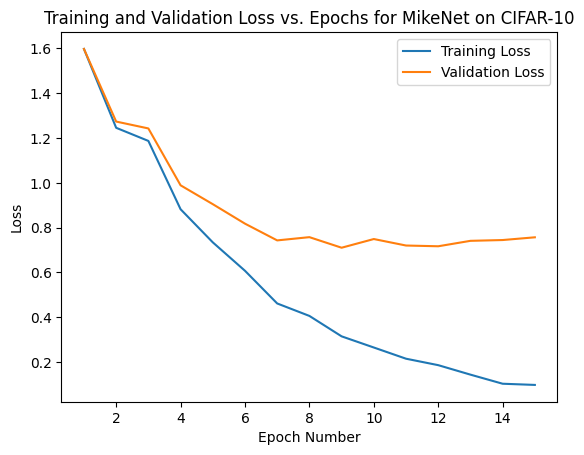

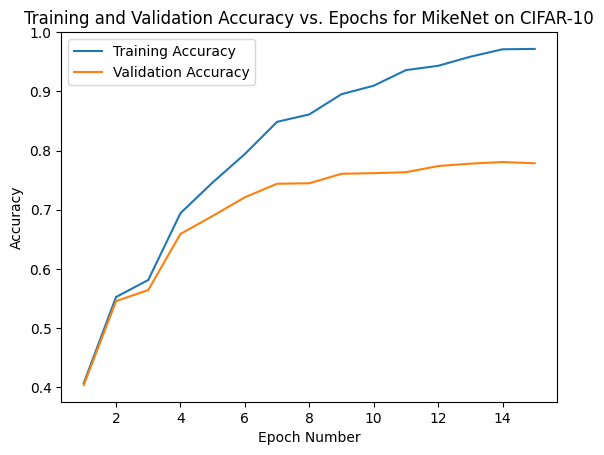

In [18]:
train_model(MikeNet())

## Original Model Analysis

### Let's look at the architecture

```
self.conv1 = nn.Conv2d(3, 128, 3) 
self.conv2 = nn.Conv2d(128, 256, 3) # input: [b, 30, 30, 128]. output: [b, 28, 28, 256]
self.dropout1 = nn.Dropout(0.4)
self.conv3 = nn.Conv2d(256, 512, 3) # input: [b, 28, 28, 256]. output: [b, 26, 26, 512]
self.dropout2 = nn.Dropout(0.4)
self.conv4 = nn.Conv2d(512, 1024, 3) # input: [b, 26, 26, 512]. output: [b, 24, 24, 1024]

self.fc1 = nn.Linear(1024 * 3 * 3, 512)
self.dropout3 = nn.Dropout(0.4)
self.fc2 = nn.Linear(512, 128)
self.fc3 = nn.Linear(128, 10)


def forward(self, x):
    x = F.relu(self.conv1(x)) # input: [b, 32, 32, 3]. output: [b, 30, 30, 128]
    x = F.max_pool2d(x, 2) # input: [b, 32, 32, 3]. output: [b, 15, 15, 128]
    x = F.relu(self.conv2(x)) # input: [b, 15, 15, 128]. output: [b, 13, 13, 256]
    x = self.dropout1(x)
    x = F.relu(self.conv3(x)) # input: [b, 13, 13, 256]. output: [b, 11, 11, 512]
    x = F.max_pool2d(x, 2) # input: [b, 11, 11, 512]. output: [b, 5, 5, 512]
    x = F.relu(self.conv4(x)) # input: [b, 5, 5, 512]. output: [b, 3, 3, 512]
    x = self.dropout2(x)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    #x = F.softmax(self.fc3(x), dim=1)
    x = self.fc3(x)
    return x

```

### Compression
In terms of compression from the convolution, I have discovered something quite silly about this network... It seems this network didn't actually compress anything at all.
That is, the compression ratio is: b * 32 * 32 * 3 / (b * 3 * 3 * 1024) = 1/3
(Again, in my defense, I really did not know what I was doing, but at least these methods formalize that I did not know wtf I was doing.)
By the data processing inequality, this part of the model is too big jusy by the fact that I am trying to "create" information

### MEC: 

(1024 * 3 * 3 + 1) * 512 + 512 + 128 = 4719744 bits MEC

### Calculating necessary MEC: 
There are 50000 data points and 10 classes. log_2(10) = 4; 4 * 50000 = 200000 bits of necessary MEC.




In [19]:
def conv_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - kernel) / stride + 1)

def pool_output_dim(input_dim, pad, kernel, stride):
    return int((input_dim + 2 * pad - (kernel - 1) - 1) / stride + 1)

In [20]:
print(conv_output_dim(14, 0, 3, 1))
print(pool_output_dim(12, 0, 2, 2))

12
6


In [21]:


X = [training_data[i][0] for i in range(len(training_data))]
X = np.array(X)
X = X.reshape(X.shape[0], -1)
y = [training_data[i][1] for i in range(len(training_data))]
y = np.array(y)
print(X.shape)
print(y.shape)

(50000, 3072)
(50000,)


(44304, 4.646442938401499, 14284.165592646208)

# Adjustments based off of MEC

Again, the upper bound for MEC is around 200000 bits. 
Let's make the MLP of the following architecture:
(1024, 256)
(256, 64)
(64, 10)
This would have (1024 + 1) * 256 + 256 + 64 = 262720 bits of MEC. (Still 62720 over necessary, but an 18x reduction from the original).

Making the input to the MLP 1024 features would also make the compression ratio of all convolutional layers 32 * 32 * 3 / 1024 = 3


### New CNN

In [22]:
class MikeNetMEC(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3) # 32 > 30
    self.conv2 = nn.Conv2d(64, 256, 3) # 30 > 28
    self.max1 = nn.MaxPool2d(2) # 28 > 14
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3) # 14 > 12
    self.max2 = nn.MaxPool2d(2) # 12 > 6
    self.dropout2 = nn.Dropout(0.4)
    
    self.conv4 = nn.Conv2d(512, 1024, 4) # 6 > 3
    self.max3 = nn.MaxPool2d(2) # 3 > 1


    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(1024, 256)
    self.dropout3 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max1(x)
    x = self.dropout1(x)  

    x = F.relu(self.conv3(x))
    x = self.max2(x)
    # print(x.shape)

    x = F.relu(self.conv4(x))
    x = self.max3(x)
    x = self.dropout2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  0%|          | 13/3334 [00:00<00:26, 126.36batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:22<00:00, 147.91batch/s]


Finished Epoch 1!
Training loss: 1.6337769972970546 ... Training accuracy: 0.39962


  1%|          | 18/3334 [00:00<00:18, 177.47batch/s]

Validation loss: 1.6312734020882282 ... Validation accuracy: 0.3954


100%|██████████| 3334/3334 [00:22<00:00, 150.02batch/s]


Finished Epoch 2!
Training loss: 1.3259923206558468 ... Training accuracy: 0.53586


  1%|          | 18/3334 [00:00<00:18, 177.27batch/s]

Validation loss: 1.3663546090898129 ... Validation accuracy: 0.5232


100%|██████████| 3334/3334 [00:21<00:00, 153.35batch/s]


Finished Epoch 3!
Training loss: 0.9921749148832943 ... Training accuracy: 0.64906


  1%|          | 18/3334 [00:00<00:18, 177.36batch/s]

Validation loss: 1.070822453525649 ... Validation accuracy: 0.6232


100%|██████████| 3334/3334 [00:21<00:00, 155.23batch/s]


Finished Epoch 4!
Training loss: 0.8093635324650206 ... Training accuracy: 0.72604


  1%|          | 18/3334 [00:00<00:19, 174.12batch/s]

Validation loss: 0.9296316135635619 ... Validation accuracy: 0.678


100%|██████████| 3334/3334 [00:21<00:00, 154.14batch/s]


Finished Epoch 5!
Training loss: 0.699372476399231 ... Training accuracy: 0.76164


  1%|          | 18/3334 [00:00<00:19, 173.23batch/s]

Validation loss: 0.8888244609469953 ... Validation accuracy: 0.6944


100%|██████████| 3334/3334 [00:22<00:00, 149.10batch/s]


Finished Epoch 6!
Training loss: 0.5342750638984837 ... Training accuracy: 0.82206


  1%|          | 18/3334 [00:00<00:18, 176.96batch/s]

Validation loss: 0.7679104702002642 ... Validation accuracy: 0.7408


100%|██████████| 3334/3334 [00:21<00:00, 151.56batch/s]


Finished Epoch 7!
Training loss: 0.4488804325255793 ... Training accuracy: 0.85042


  1%|          | 18/3334 [00:00<00:18, 176.78batch/s]

Validation loss: 0.7467129247310548 ... Validation accuracy: 0.7495


100%|██████████| 3334/3334 [00:23<00:00, 144.48batch/s]


Finished Epoch 8!
Training loss: 0.3699422031931521 ... Training accuracy: 0.87998


  1%|          | 18/3334 [00:00<00:18, 175.18batch/s]

Validation loss: 0.7293612792462423 ... Validation accuracy: 0.7548


100%|██████████| 3334/3334 [00:19<00:00, 169.53batch/s]


Finished Epoch 9!
Training loss: 0.30241737547919967 ... Training accuracy: 0.9069


  1%|          | 18/3334 [00:00<00:18, 176.26batch/s]

Validation loss: 0.7184052040976384 ... Validation accuracy: 0.7609


100%|██████████| 3334/3334 [00:22<00:00, 148.03batch/s]


Finished Epoch 10!
Training loss: 0.22561554997504635 ... Training accuracy: 0.9295


  1%|          | 18/3334 [00:00<00:18, 175.66batch/s]

Validation loss: 0.7150730371888521 ... Validation accuracy: 0.7706


100%|██████████| 3334/3334 [00:20<00:00, 165.59batch/s]


Finished Epoch 11!
Training loss: 0.2044343507385533 ... Training accuracy: 0.93984


  1%|          | 18/3334 [00:00<00:18, 178.07batch/s]

Validation loss: 0.6970824505659058 ... Validation accuracy: 0.7728


100%|██████████| 3334/3334 [00:21<00:00, 152.80batch/s]


Finished Epoch 12!
Training loss: 0.15866899100899357 ... Training accuracy: 0.95274


  1%|          | 18/3334 [00:00<00:18, 176.56batch/s]

Validation loss: 0.7049850133740563 ... Validation accuracy: 0.778


100%|██████████| 3334/3334 [00:22<00:00, 145.05batch/s]


Finished Epoch 13!
Training loss: 0.14774061274523698 ... Training accuracy: 0.95646


  1%|          | 18/3334 [00:00<00:18, 177.29batch/s]

Validation loss: 0.751411735341288 ... Validation accuracy: 0.7716


100%|██████████| 3334/3334 [00:20<00:00, 160.17batch/s]


Finished Epoch 14!
Training loss: 0.10769110910771705 ... Training accuracy: 0.96946


  1%|          | 18/3334 [00:00<00:18, 178.65batch/s]

Validation loss: 0.7488229367854088 ... Validation accuracy: 0.7777


100%|██████████| 3334/3334 [00:19<00:00, 169.28batch/s]


Finished Epoch 15!
Training loss: 0.07743897061905615 ... Training accuracy: 0.97986
Validation loss: 0.7666022279544146 ... Validation accuracy: 0.778


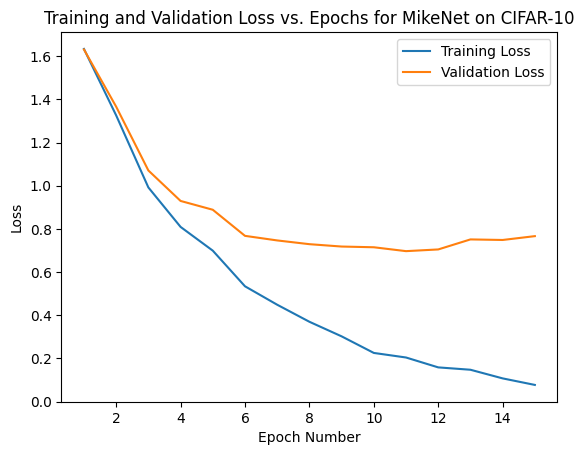

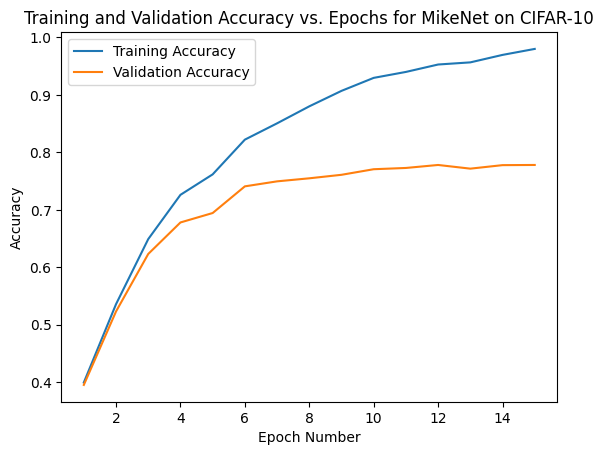

In [23]:
train_model(MikeNetMEC())


### Analysis
Okay, so reducing the MLP by around 20x did not reduce training accuracy! That's cool. However, I still have dropout in this network... I wonder if I can delete all of the dropout layers and still maintain a similar level of accuracy...

In [31]:
class MikeNetNoDropout(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3) # 32 > 30
    self.conv2 = nn.Conv2d(64, 256, 3) # 30 > 28
    self.max1 = nn.MaxPool2d(2) # 28 > 14
    self.dropout1 = nn.Dropout(0.4)
    self.conv3 = nn.Conv2d(256, 512, 3) # 14 > 12
    self.max2 = nn.MaxPool2d(2) # 12 > 6
    self.dropout2 = nn.Dropout(0.4)
    
    self.conv4 = nn.Conv2d(512, 512, 4) # 6 > 3
    self.max3 = nn.MaxPool2d(2) # 3 > 1


    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(512, 10)
    self.dropout3 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max1(x)
    # x = self.dropout1(x)  

    x = F.relu(self.conv3(x))
    x = self.max2(x)
    # print(x.shape)

    x = F.relu(self.conv4(x))
    x = self.max3(x)
    # x = self.dropout2(x)

    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    # x = self.dropout3(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  1%|          | 19/3334 [00:00<00:18, 180.39batch/s]

Using device cuda


100%|██████████| 3334/3334 [00:20<00:00, 164.85batch/s]


Finished Epoch 1!
Training loss: 1.867406203171845 ... Training accuracy: 0.29812


  1%|          | 22/3334 [00:00<00:15, 211.39batch/s]

Validation loss: 1.8625643864564452 ... Validation accuracy: 0.2965


100%|██████████| 3334/3334 [00:19<00:00, 168.76batch/s]


Finished Epoch 2!
Training loss: 1.284630129597612 ... Training accuracy: 0.52544


  1%|          | 21/3334 [00:00<00:16, 199.25batch/s]

Validation loss: 1.3243576128264776 ... Validation accuracy: 0.5133


100%|██████████| 3334/3334 [00:19<00:00, 169.31batch/s]


Finished Epoch 3!
Training loss: 0.8985805293365231 ... Training accuracy: 0.69184


  1%|          | 21/3334 [00:00<00:15, 209.06batch/s]

Validation loss: 1.0170687911571235 ... Validation accuracy: 0.6414


100%|██████████| 3334/3334 [00:22<00:00, 149.52batch/s]


Finished Epoch 4!
Training loss: 0.678906391432311 ... Training accuracy: 0.76922


  1%|          | 20/3334 [00:00<00:17, 189.98batch/s]

Validation loss: 0.8993963399256902 ... Validation accuracy: 0.6947


100%|██████████| 3334/3334 [00:18<00:00, 175.51batch/s]


Finished Epoch 5!
Training loss: 0.5775566989758197 ... Training accuracy: 0.80468


  1%|          | 21/3334 [00:00<00:16, 205.92batch/s]

Validation loss: 0.9291428307230505 ... Validation accuracy: 0.7023


100%|██████████| 3334/3334 [00:19<00:00, 169.52batch/s]


Finished Epoch 6!
Training loss: 0.34354084787971884 ... Training accuracy: 0.88886


  1%|          | 20/3334 [00:00<00:17, 194.50batch/s]

Validation loss: 0.8548926651433133 ... Validation accuracy: 0.7295


100%|██████████| 3334/3334 [00:22<00:00, 149.57batch/s]


Finished Epoch 7!
Training loss: 0.26681641396651873 ... Training accuracy: 0.91234


  1%|          | 20/3334 [00:00<00:16, 199.23batch/s]

Validation loss: 0.9500784876866677 ... Validation accuracy: 0.723


100%|██████████| 3334/3334 [00:21<00:00, 151.96batch/s]


Finished Epoch 8!
Training loss: 0.21642355625665716 ... Training accuracy: 0.92924


  1%|          | 21/3334 [00:00<00:16, 205.00batch/s]

Validation loss: 0.9889535692253749 ... Validation accuracy: 0.7255


100%|██████████| 3334/3334 [00:19<00:00, 171.32batch/s]


Finished Epoch 9!
Training loss: 0.13342008320056015 ... Training accuracy: 0.95768


  1%|          | 21/3334 [00:00<00:15, 209.12batch/s]

Validation loss: 1.083324290893 ... Validation accuracy: 0.7373


100%|██████████| 3334/3334 [00:20<00:00, 161.04batch/s]


Finished Epoch 10!
Training loss: 0.152123853722509 ... Training accuracy: 0.94966


  1%|          | 21/3334 [00:00<00:16, 206.46batch/s]

Validation loss: 1.0730538206367657 ... Validation accuracy: 0.7298


100%|██████████| 3334/3334 [00:21<00:00, 158.66batch/s]


Finished Epoch 11!
Training loss: 0.16014963147657243 ... Training accuracy: 0.94788


  1%|          | 21/3334 [00:00<00:16, 205.98batch/s]

Validation loss: 1.3384339052630865 ... Validation accuracy: 0.7149


100%|██████████| 3334/3334 [00:20<00:00, 160.57batch/s]


Finished Epoch 12!
Training loss: 0.11680187168511043 ... Training accuracy: 0.96268


  1%|          | 24/3334 [00:00<00:14, 235.94batch/s]

Validation loss: 1.3013014219438788 ... Validation accuracy: 0.7296


100%|██████████| 3334/3334 [00:17<00:00, 186.60batch/s]


Finished Epoch 13!
Training loss: 0.07317768211601283 ... Training accuracy: 0.978


  1%|          | 20/3334 [00:00<00:17, 193.47batch/s]

Validation loss: 1.2689906169670513 ... Validation accuracy: 0.7396


100%|██████████| 3334/3334 [00:19<00:00, 171.60batch/s]


Finished Epoch 14!
Training loss: 0.08789367772077566 ... Training accuracy: 0.97292


  1%|          | 21/3334 [00:00<00:16, 204.58batch/s]

Validation loss: 1.4351227146027417 ... Validation accuracy: 0.7306


100%|██████████| 3334/3334 [00:19<00:00, 173.22batch/s]


Finished Epoch 15!
Training loss: 0.07465787801036905 ... Training accuracy: 0.9771
Validation loss: 1.3598232259157057 ... Validation accuracy: 0.7443


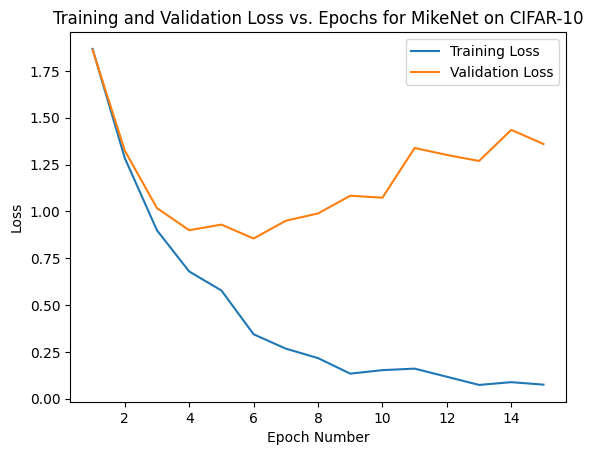

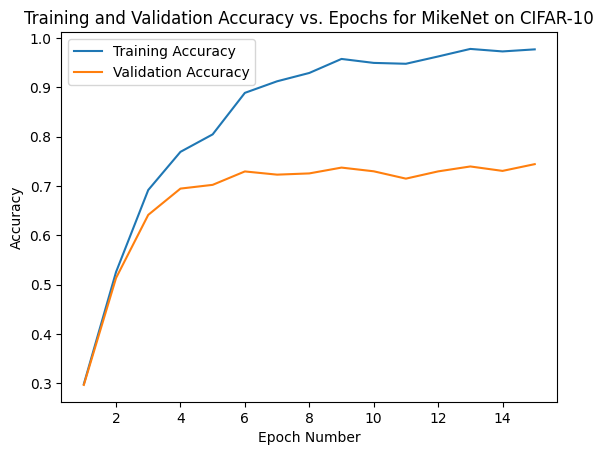

In [32]:
train_model(MikeNetNoDropout())

### Notes on this experiment
This overfits.
If I try to make the first MLP hidden layer size any larger, it overfits more than this, and if I try to make the size of the input to the MLP any smaller (i.e overcompress in the convolutional layers), it overfits more. 
However, I reduced the MLP MEC 900x and only lost around 4% validation accuracy. 
I think this would go better with some different training hyperparameters (e.g. learn rate, batch size, optimizer) and maybe changing some of the convolutional choices, but the point of this experiment was to see how much I could push reducing the MEC only.
